In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

import numpy as np
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor

In [2]:
transform = Compose([ToTensor()])
dataset = MNIST('dataset/', train=True, transform=transform, download=True)
# dataset = CIFAR10('dataset/', train=True, transform=transform, download=True)

loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
x,y = next(iter(loader))
x.shape

torch.Size([64, 1, 28, 28])

In [4]:
import AttentionMap

model = nn.Sequential(*[
    nn.Conv2d(1, 4, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    AttentionMap.Conv2d(4, 12, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Flatten(start_dim=1),
    nn.Linear(588, 128),
    # nn.Linear(8*8*12, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 10),
    # nn.LogSoftmax(dim=1)
])

In [5]:
from tqdm import tqdm

n_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(loader):
        input = input.to(device)
        target = target.to(device)

        out = model(input)
        loss = criterion(out, target)

        if idx % 500 == 0:
            epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [01:58<00:00, 11.88s/epoch, tls=0.0482]


In [32]:
input_lvl3 = model[:3](input.to(device))
am = model[3]
att = am.attention_map(input_lvl3.to(device))[0].detach().cpu()
conv = am.conv(input_lvl3.to(device))[0].detach().cpu()
result = am(input_lvl3.to(device))[0].detach().cpu()

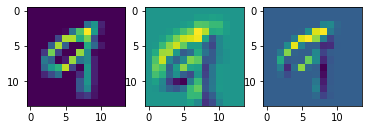

In [33]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,3)
ax[0].imshow(att[0].detach().cpu())
ax[1].imshow(conv[0].detach().cpu())
ax[2].imshow(result[0].detach().cpu())
plt.show()

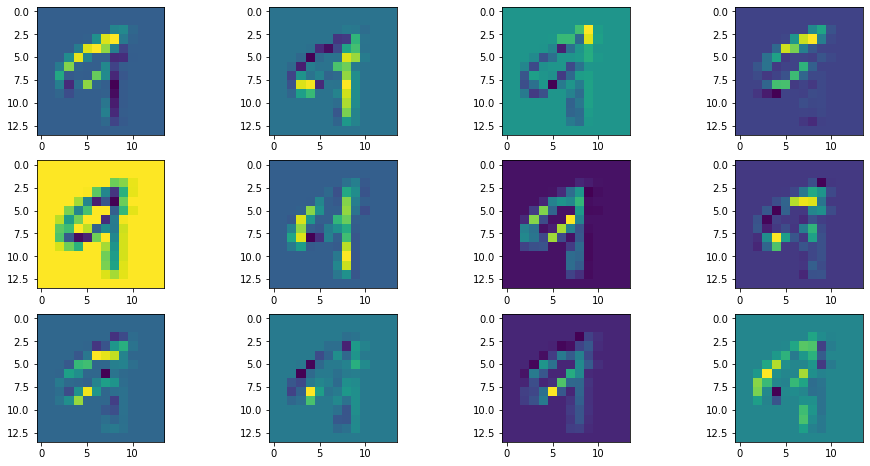

In [34]:
fig, ax = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(result[(i*4)+j])

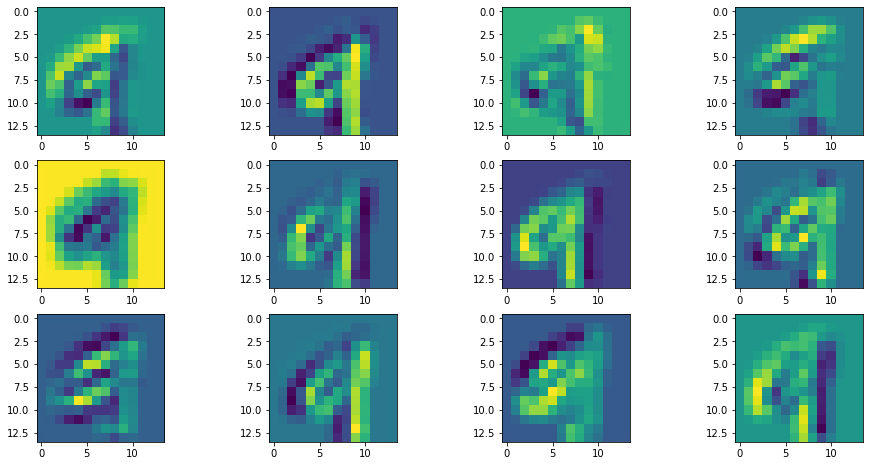

In [35]:
fig, ax = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(conv[(i*4)+j])

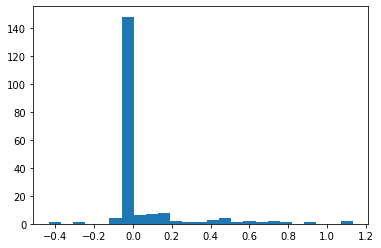

In [10]:
plt.hist(result[0].detach().cpu().flatten().numpy(), bins=25)
plt.show()

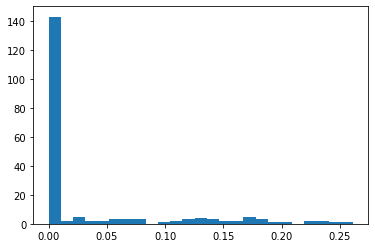

In [11]:
plt.hist(att[0].cpu().flatten().detach().numpy(), bins=25)
plt.show()

In [12]:
model_2 = nn.Sequential(*[
    nn.Conv2d(1, 4, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(4, 12, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Flatten(start_dim=1),
    nn.Linear(588, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 10),
    # nn.LogSoftmax(dim=1)
])

In [13]:
from tqdm import tqdm

n_epoch = 10
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_2 = model_2.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(loader):
        input = input.to(device)
        target = target.to(device)

        out = model_2(input)
        loss = criterion(out, target)

        if idx % 500 == 0:
            epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [01:37<00:00,  9.73s/epoch, tls=0.0017]


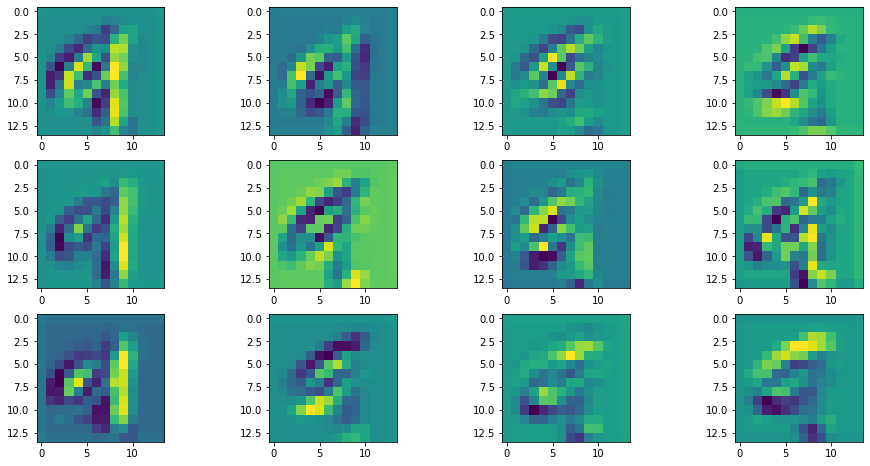

In [22]:
input_lvl3 = model_2[:3](input.to(device))
am = model_2[3]
result = am(input_lvl3.to(device))[0].detach().cpu()

fig, ax = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(result[(i*4)+j])

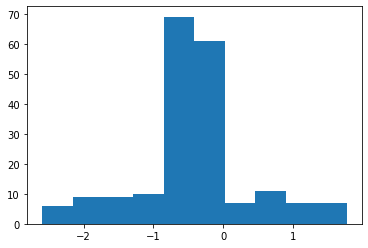

In [15]:
plt.hist(result[0].detach().cpu().flatten().numpy())
plt.show()